# Emily Tseng (et397) Ex1

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

from Ex1data import absdata
from collections import Counter, defaultdict
import re

## 0) Load data

In [2]:
assert sorted(absdata) == ['astro-ph.GA', 'cond-mat.mes-hall', 'cs.CV', 'cs.HC', 'cs.LG', 'hep-ph', 'hep-th', 'math.AP', 'physics.app-ph', 'physics.comp-ph', 'q-bio.NC', 'quant-ph']

In [3]:
assert Counter( re.findall("[a-z0-9']+", absdata['cs.HC'][0].lower()) ).most_common(20)[1] == ('the', 7)

## 1) Zipf's Law

In [4]:
vocab = Counter()
for subj in ('cs.HC', 'cs.LG'):
    for txt in absdata[subj]:
       vocab += Counter( re.findall("[a-z0-9']+", txt.lower()) )

In [5]:
assert len(vocab) == 13861
assert sum(vocab.values()) > 300000

In [6]:
top10000 = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:10000]
top10000counts = [tup[1] for tup in top10000]

### Rank-frequency plot of raw word occurrences

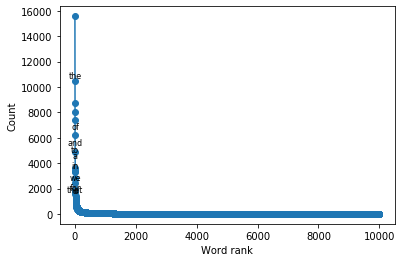

In [36]:
plt.plot(top10000counts, marker='o')
plt.xlabel('Word rank')
plt.ylabel('Count')
for i, (xval,yval,word) in enumerate(zip(x, [x[1] for x in top10000], [x[0] for x in top10000])):
    if i == 10:
        break
    plt.text(xval,.1*yval**1.2,word,ha='center', fontsize=8)
plt.show()

### A) Rank-frequency plot of log word occurrences

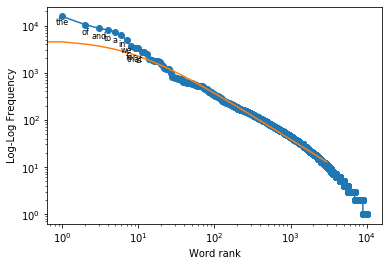

In [50]:
x = 1+np.arange(10000)
plt.loglog(x, top10000counts, marker='o')
fitx = np.log(x)[7:3000]
fity = np.log(top10000counts)[7:3000]
m, b, r, p, stderr = linregress(fitx, fity)
plt.plot(np.exp(m*fitx+b), '-')
plt.xlabel('Word rank')
plt.ylabel('Log-Log Frequency')
for i, (xval,yval,word) in enumerate(zip(x, [x[1] for x in top10000], [x[0] for x in top10000])):
    if i == 10:
        break
    plt.text(xval,.1*yval**1.2,word,ha='center', fontsize=8)
plt.show()

### B) Corpus counts

i) What percentage of the corpus is made up of the top 10, top 25, and top 100 ranked words?

In [53]:
def get_corpus_percentage(vocab, n):
    """
        Inputs: 
            <dict> vocab
            <int> n: top N to pull
        Output:
            <float> percentage of the corpus that is made up of the top n ranked words
    """
    topNcounts = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:n]
    return sum([x[1] for x in topNcounts]) / sum(vocab.values())


In [61]:
print('The top 10 ranked words constitute approx. {} percent of the corpus.'.format(round(get_corpus_percentage(vocab, 10) * 100)))
print('The top 25 ranked words constitute approx. {} percent of the corpus.'.format(round(get_corpus_percentage(vocab, 25) * 100)))
print('The top 100 ranked words constitute approx. {} percent of the corpus.'.format(round(get_corpus_percentage(vocab, 100) * 100)))

The top 10 ranked words constitute approx. 24 percent of the corpus.
The top 25 ranked words constitute approx. 33 percent of the corpus.
The top 100 ranked words constitute approx. 46 percent of the corpus.


ii) For this corpus, what number of top ranked words make up 25, 50, and 75% of the corpus?

In [104]:
def get_number_words(vocab, n):
    """
        Inputs: 
            <dict> vocab
            <int> n: percentage of the corpus to pull
        Output:
            <int> number of top-ranked words that constitute n percent of the corpus
        Note this method rounds up, i.e. if the top 10 words constitute 24% and the top 11 words 
        constitute 26%, it will return 26%. 
    """
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
    denom = sum(vocab.values())
    sorted_vocab_percentages = [(x, float(y/denom)) for (x, y) in sorted_vocab]
    output = 0
    cum_percent = 0.
    for word, percentage in sorted_vocab_percentages:
        cum_percent += percentage
        output += 1
        if float(cum_percent * 100) > n:
            return output
    return output

In [105]:
print('The top {} words make up approx. {}pct of the corpus.'.format(get_number_words(vocab, 25), 25))
print('The top {} words make up approx. {}pct of the corpus.'.format(get_number_words(vocab, 50), 50))
print('The top {} words make up approx. {}pct of the corpus.'.format(get_number_words(vocab, 75), 75))


The top 12 words make up approx. 25pct of the corpus.
The top 143 words make up approx. 50pct of the corpus.
The top 931 words make up approx. 75pct of the corpus.


iii) For each of the numbers in ii), what percentage of the vocabulary do they represent?

In [106]:
def get_vocab_percent(vocab, n):
    """
        Inputs: 
            <dict> vocab
            <int> n: number of words
        Output:
            <float> the percentage of the vocabulary represented in the top n words 
    """
    return float(n / len(vocab)) * 100

In [107]:
n25 = get_number_words(vocab, 25)
print('The top {} words represent {}pct of the vocabulary.'.format(n25, get_vocab_percent(vocab, n25)))
n50 = get_number_words(vocab, 50)
print('The top {} words represent {}pct of the vocabulary.'.format(n50, get_vocab_percent(vocab, n50)))
n75 = get_number_words(vocab, 75)
print('The top {} words represent {}pct of the vocabulary.'.format(n75, get_vocab_percent(vocab, n75)))

The top 12 words represent 0.0865738402712647pct of the vocabulary.
The top 143 words represent 1.0316715965659042pct of the vocabulary.
The top 931 words represent 6.7166871077122865pct of the vocabulary.


## 2) Naive Bayes text classifier

In [227]:
class NaiveBayes:
    def __init__(self, classes, vocab):
        self.classes = classes
        self.vocab = vocab
        self.unk_index = self.vocab.index('<UNK>')
        # Init with add-one smoothing
        self.words_counts = np.ones((len(classes), len(vocab)))
    
    def tokenize(self, x):
        return re.findall("[a-z0-9']+", x.lower())

    def train(self, train_X, train_Y):
        for x, y in zip(train_X, train_Y):
            class_idx = self.classes.index(y)
            words = self.tokenize(x)
            for word in words:
                self.words_counts[class_idx, self.vocab.index(word)] += 1
    
    def predict(self, X):
        class_probs = np.zeros((len(self.classes),))
        for word in self.tokenize(X):
            if word in self.vocab:
                word_idx = self.vocab.index(word)
            else:
                word_idx = self.unk_index
            word_in_class_probs = self.words_counts[:,word_idx] / np.sum(self.words_counts, axis=1)
            for class_idx, y in enumerate(self.classes):
                class_probs[class_idx] += np.log(word_in_class_probs[class_idx])
        class_probs = class_probs / np.sum(class_probs)
        output = self.classes[np.argmin(class_probs)]
        return output

            

In [228]:
classes = ['cs.HC', 'cs.LG', 'cs.CV', 'q-bio.NC']

# Assemble training data
train_X = list()
train_y = list()
vocab = set(["<UNK>"])

n = 900
for y in classes:
    train_X.extend(absdata[y][:n])
    train_y.extend([y for i in range(n)])
    for txt in absdata[y][:n]:
        vocab = vocab.union(set(re.findall("[a-z0-9']+", txt.lower())))
vocab_list = list(vocab)

assert len(train_X) == (4*n)
assert len(train_X) == len(train_y)
print(len(vocab_list))

19219


In [229]:
model = NaiveBayes(classes, vocab_list)
model.train(train_X, train_y)

In [231]:
# Assemble testing data
test_X = list()
test_y = list()

n = 100
for y in classes:
    test_X.extend(absdata[y][-n:])
    test_y.extend([y for i in range(n)])

correct = 0
total = len(test_X)
for X, y in zip(test_X, test_y):
    yhat = model.predict(X)
    if yhat == y:
        correct += 1

print('Test acc: {}'.format(float(correct / total)))

Test acc: 0.89


## 3) Bayes' Rule